# Sentiment Analysis using Movie Reviews Dataset


## Imports

In [1]:
# after installation and upgrade kernel restart needed
!pip install -q --upgrade keras-nlp
!pip install -q --upgrade keras

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from datetime import datetime
import keras_nlp
import numpy as np
import re
import shutil
import shap
from sklearn.metrics import classification_report
import tensorflow as tf


tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# matplotlib settings
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', size=10)
plt.rc('axes', labelsize=10, titlesize=12)
plt.rc('legend', fontsize=9)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

## Data
1. Load the movie reviews dataset from a source.
2. Split it into training/validation subsets using a standard 80/20 split.
3. Overview the data to obtain some basic statistics (such as vocabulary size, mean, and standard deviation).
4. Configure the datasets for performance.

In [3]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")
os.listdir(dataset_dir)

['train', 'imdb.vocab', 'test', 'README', 'imdbEr.txt']

In [4]:
# set training and testing data paths
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test")

os.listdir(train_dir)

['urls_pos.txt',
 'urls_unsup.txt',
 'neg',
 'urls_neg.txt',
 'labeledBow.feat',
 'unsupBow.feat',
 'pos',
 'unsup']

In [5]:
# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [6]:
# create datasets
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, batch_size=batch_size, validation_split=0.2,
    subset='training', seed=seed)

val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, batch_size=batch_size, validation_split=0.2,
    subset='validation', seed=seed)

test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir, batch_size=batch_size)

class_labels = train_ds.class_names
print("\nClass names:", class_labels)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.

Class names: ['neg', 'pos']


In [7]:
# data examples
for review, label in train_ds.unbatch().take(3):
    print(f"\nReview: {review}")
    print(f"Label: {class_labels[label]}: ({label})")


Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label: neg: (0)

Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as th

In [10]:
# concat reviews texts from train and validation datasets discarding labels 
reviews = tf.concat(([review for review, _ in train_ds.unbatch()], 
                     [review for review, _ in val_ds.unbatch()]), axis=0)
# TextVectorization layer allows efficiently extract vocabulary from the text 
# while optionally appling standardization to it
vectorizer = tf.keras.layers.TextVectorization()
vectorizer.adapt(reviews)
# compute the number of tokens per each review
bows = vectorizer(reviews)
counts = tf.math.count_nonzero(bows, axis=1, keepdims=True)
# get a mean and standard deviation of reviews word counts 
mean, std = tf.math.reduce_mean(counts), tf.math.reduce_std(tf.cast(counts, dtype=tf.float32))
min, max = tf.reduce_min(counts), tf.reduce_max(counts)

print("Number of unique words in both train and valid datasets:", vectorizer.vocabulary_size())
print(f"Reviews contain {mean} words on average, with standard deviation of {std} words")
print(f"Minimum/maximum review word count: {min}/{max}")

Number of unique words in both train and valid datasets: 121894
Reviews contain 232 words on average, with standard deviation of 173.0606689453125 words
Minimum/maximum review word count: 10/2469


In [11]:
# configure datasets for performance
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

## Model Setup
1. Create utility functions for model training and performance comparison.
2. Set up baseline model performance (using a pre-trained model, no fine-tuning).

The model used throughout the notebook for this task is the pretrained BERT classifier, specifically its 'bert_tiny_en_uncased' variant provided by KerasNLP. The backbone model used by this model has already been fine-tuned on the SST-2 sentiment analysis dataset.

In [12]:
# utility function to load the model
def get_model(dropout=0.1):
    """Returns bert_tiny_en_uncased model optionally appling
    dropout, where droput=0.1 is the default."""
    
    model = keras_nlp.models.BertClassifier.from_preset(
        "bert_tiny_en_uncased_sst2",
        num_classes=2,
        dropout=dropout,
    )
    return model

In [13]:
model = get_model()
model.summary(expand_nested=True)

Preprocessor: "bert_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                     │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 128), (None,      │       4,385,920 │ padding_mask[0][0],        │
│                               │ None, 128)]               │                 │ segment_ids[0][0],         │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│    └ token_ids (InputLayer)   │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│    └ token_embedding          │ (None, None, 128)         │       3,906,816 │ -                          │
│ (ReversibleEmbedding)         │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│    └ segment_ids (InputLayer) │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│    └ position_embedding       │ (None, None, 128)         │          65,536 │ -                          │
│ (PositionEmbedding)           │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│    └ segment_embedding        │ (None, None, 128)         │             256 │ -                          │
│ (Embedding)                   │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│    └ add (Add)                │ (None, None, 128)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│    └ embeddings_layer_norm    │ (None, None, 128)         │             256 │ -                          │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│    └ embeddings_dropout       │ (None, None, 128)         │               0 │ -                          │
│ (Dropout)                     │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│    └ padding_mask             │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 4,386,178 (16.73 MB)

 Trainable params: 4,386,178 (16.73 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# save model performance to compare later
accuracy = {}

In [22]:
# evaluate base model with default parameters
model = get_model()
# get model's preset learning rate
print("Default learning rate:", model.optimizer.get_config()["learning_rate"])
_ = model.fit(train_ds, validation_data=val_ds, epochs=1)
# get performance
accuracy["Baseline"] = (get_performance(model, train_ds), get_performance(model, val_ds))
print("Baseline model performance on the validation set:", accuracy["Baseline"][1])

Default learning rate: 4.999999873689376e-05
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 30ms/step - loss: 0.3945 - sparse_categorical_accuracy: 0.8277 - val_loss: 0.3172 - val_sparse_categorical_accuracy: 0.8622
Baseline model performance on the validation set: 0.8622000217437744


## Model Fine-Tuning
1. Fine-tune the model using the general recommendations for BERT model fine-tuning stability outlined in the paper - https://www.lsv.uni-saarland.de/wp-content/publications/2020/On_the_Stability_of_Fine-tuning_BERT_preprint.pdf: increase the number of training steps (20 epochs), use a learning rate of 2e-5 (increase the learning rate for the first 10% of steps, then linearly decay it to zero afterward), utilize early stopping on the validation performance.
2. Apply a simpler form of fine-tuning using a constant learning rate of 2e-5, reduce the number of epochs to 5.
3. Experiment with different sets of model hyperparameters (increase the number of epochs, use a constant learning rate, add early stopping).
4. Compare the results obtained with the established baseline.

In [21]:
# helper function to visualize model training curves
def plot_history(history):
    """Plots training curves given training and validation 
    (accuracy, loss) keys provided in the history."""

    # get keys from the dictionary 
    hist_keys = list(history.history.keys())
    # performance plot
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
    ax1.plot(history.history[hist_keys[0]])
    ax1.plot(history.history[hist_keys[2]])
    ax1.set_title('Model Loss')
    ax1.set_ylabel(hist_keys[0])
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'valid'], loc='upper left')
    ax1.grid(True)
    # loss plot
    ax2.plot(history.history[hist_keys[1]])
    ax2.plot(history.history[hist_keys[3]])
    ax2.set_title('Model Accuracy')
    ax2.set_ylabel(hist_keys[1])
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'valid'], loc='upper right')
    ax2.grid(True)
    plt.tight_layout()
    plt.show()

def get_performance(model, dataset, metric="sparse_categorical_accuracy"):
    """Evaluates model on a given dataset and returns specified metric value"""
    return model.evaluate(dataset, return_dict=True, verbose=0)[metric]

# def plot compare models
def plot_stats(stats):
    """Given a dictionary of (model name, model performance)
    items outputs comparative plot."""

    mode = ("Train", "Valid")
    models = list(stats.keys())
    x = np.arange(len(models))  # the label locations
    y = np.round(np.array(list(accuracy.values())), 3)
    y1, y2 = y[:, 0], y[:, 1]
    width = 0.15  # the width of the bars
    plt.figure(figsize=(4, 3), layout='constrained')
    bar1 = plt.bar(x-0.1, y1, width) 
    bar2 = plt.bar(x+0.1, y2, width)
    plt.bar_label(bar1)
    plt.bar_label(bar2)
    plt.xticks(x, models)
    plt.ylim(0.8)
    plt.title("Models training/validation set performance")
    plt.legend(mode, loc='upper left', ncols=2)
    plt.grid(True)
    plt.show()

In [18]:
# TF Model Optimization is not compatible with keras3 yet
# class copied as is from the official repository: https://github.com/tensorflow/models/blob/v2.15.0/official/modeling/optimization/lr_schedule.py#L92-L162
from typing import Mapping, Any, Union, Optional

class LinearWarmup(tf.keras.optimizers.schedules.LearningRateSchedule):
  """Linear warmup schedule."""

  def __init__(self,
               after_warmup_lr_sched: Union[
                   tf.keras.optimizers.schedules.LearningRateSchedule, float],
               warmup_steps: int,
               warmup_learning_rate: float,
               name: Optional[str] = None):
    """Add linear warmup schedule to a learning rate schedule.

    warmup_lr is the initial learning rate, the final learning rate of the
    init_warmup period is the initial learning rate of lr_schedule in use.
    The learning rate at each step linearly increased according to the following
    formula:
      learning_rate = warmup_lr + step / warmup_steps
                    * (final_warmup_lr - warmup_lr).
    Using warmup overrides the learning rate schedule by the number of warmup
    steps.

    Args:
      after_warmup_lr_sched: tf.keras.optimizers.schedules .LearningRateSchedule
        or a constant.
      warmup_steps: Number of the warmup steps.
      warmup_learning_rate: Initial learning rate for the warmup.
      name: Optional, name of warmup schedule.
    """
    super().__init__()
    self._name = name
    self._after_warmup_lr_sched = after_warmup_lr_sched
    self._warmup_steps = warmup_steps
    self._init_warmup_lr = warmup_learning_rate
    if isinstance(after_warmup_lr_sched,
                  tf.keras.optimizers.schedules.LearningRateSchedule):
      self._final_warmup_lr = after_warmup_lr_sched(warmup_steps)
    else:
      self._final_warmup_lr = tf.cast(after_warmup_lr_sched, dtype=tf.float32)

  def __call__(self, step: int):

    global_step = tf.cast(step, dtype=tf.float32)

    linear_warmup_lr = (
        self._init_warmup_lr + global_step / self._warmup_steps *
        (self._final_warmup_lr - self._init_warmup_lr))

    if isinstance(self._after_warmup_lr_sched,
                  tf.keras.optimizers.schedules.LearningRateSchedule):
      after_warmup_lr = self._after_warmup_lr_sched(step)
    else:
      after_warmup_lr = tf.cast(self._after_warmup_lr_sched, dtype=tf.float32)

    lr = tf.cond(global_step < self._warmup_steps,
                 lambda: linear_warmup_lr,
                 lambda: after_warmup_lr)
    return lr

  def get_config(self) -> Mapping[str, Any]:
    if isinstance(self._after_warmup_lr_sched,
                  tf.keras.optimizers.schedules.LearningRateSchedule):
      config = {
          "after_warmup_lr_sched": self._after_warmup_lr_sched.get_config()}  # pytype: disable=attribute-error
    else:
      config = {"after_warmup_lr_sched": self._after_warmup_lr_sched}  # pytype: disable=attribute-error

    config.update({
        "warmup_steps": self._warmup_steps,
        "warmup_learning_rate": self._init_warmup_lr,
        "name": self._name
    })
    return config

In [ ]:
class TriangularSchedulers(keras.optimizers.schedules.LearningRateSchedule):
    """Linear ramp up for 'warmup' steps, then linear decay to 0 at 'total steps'."""
    

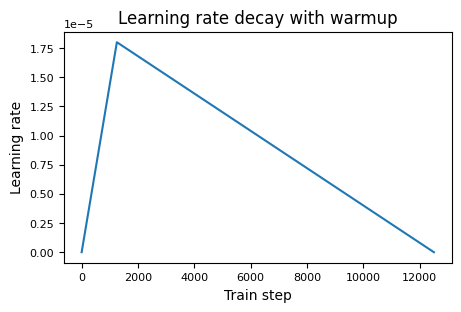

In [19]:
# set up learning rate scheduler (based on BERT stable fine-tuning paper)
epochs = 20
batch_size = 32
steps_per_epoch = train_ds.cardinality().numpy()
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(0.1 * num_train_steps)
initial_learning_rate = 2e-5

# linear learning rate decay applied after "warmup_steps"
linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    end_learning_rate=0,
    decay_steps=num_train_steps)
# linear warmup for "warmup_steps" steps
warmup_schedule = LinearWarmup(
    warmup_learning_rate=0,
    after_warmup_lr_sched=linear_decay,
    warmup_steps=warmup_steps
)

# plot resulting learning rate scheduling strategy
plt.figure(figsize=(5, 3))
x = tf.linspace(0, num_train_steps, 1001)
y = [warmup_schedule(xi) for xi in x]
plt.plot(x, y)
plt.title("Learning rate decay with warmup")
plt.xlabel('Train step')
plt.ylabel('Learning rate')
plt.show()

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 31ms/step - loss: 0.4620 - sparse_categorical_accuracy: 0.7868 - val_loss: 0.3859 - val_sparse_categorical_accuracy: 0.8274
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - loss: 0.3822 - sparse_categorical_accuracy: 0.8330 - val_loss: 0.3368 - val_sparse_categorical_accuracy: 0.8552
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - loss: 0.3378 - sparse_categorical_accuracy: 0.8558 - val_loss: 0.3132 - val_sparse_categorical_accuracy: 0.8670
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - loss: 0.3005 - sparse_categorical_accuracy: 0.8766 - val_loss: 0.3009 - val_sparse_categorical_accuracy: 0.8742
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - loss: 0.2716 - sparse_categorical_accuracy: 0.8886 - val_loss: 0.2931 - val_sparse_categorical_accuracy: 0.8800
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - loss: 0.2507 - sparse_categorical_accuracy: 0.8999 - val_loss: 0.2907 - val_sparse_categorical_accuracy:

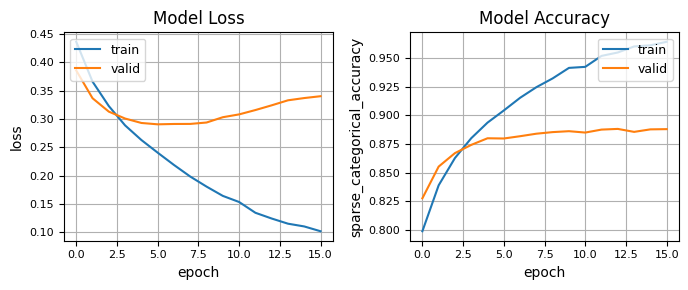

Model performance on the validation set: 0.8881999850273132


In [23]:
# train model, save performance
model = get_model(dropout=0.1)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=warmup_schedule), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=["sparse_categorical_accuracy"])
e_stop = tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_sparse_categorical_accuracy", restore_best_weights=True)
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[e_stop])

# plot summary
plot_history(history)
accuracy["FT-1"] = (get_performance(model, train_ds), get_performance(model, val_ds))
print("Model performance on the validation set:", accuracy["FT-1"][1])

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 30ms/step - loss: 0.4106 - sparse_categorical_accuracy: 0.8171 - val_loss: 0.3327 - val_sparse_categorical_accuracy: 0.8556
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - loss: 0.3301 - sparse_categorical_accuracy: 0.8618 - val_loss: 0.3083 - val_sparse_categorical_accuracy: 0.8720
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - loss: 0.2885 - sparse_categorical_accuracy: 0.8821 - val_loss: 0.2966 - val_sparse_categorical_accuracy: 0.8800
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - loss: 0.2562 - sparse_categorical_accuracy: 0.8978 - val_loss: 0.2872 - val_sparse_categorical_accuracy: 0.8828
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - loss: 0.2336 - sparse_categorical_accuracy: 0.9087 - val_loss: 0.2863 - val_sparse_categorical_accuracy: 0.8844


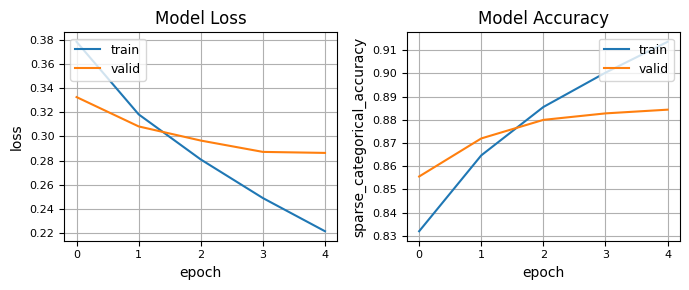

Model performance on the validation set: 0.8844000101089478


In [24]:
# default dropout, lower number of training epochs, constant learning rate
model_1 = get_model(dropout=0.1)
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=["sparse_categorical_accuracy"])
history = model_1.fit(train_ds, validation_data=val_ds, epochs=5)

# plot summary
plot_history(history)
accuracy["FT-2"] = (get_performance(model_1, train_ds), get_performance(model_1, val_ds))
print("Model performance on the validation set:", accuracy["FT-2"][1])

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - loss: 0.4121 - sparse_categorical_accuracy: 0.8133 - val_loss: 0.3337 - val_sparse_categorical_accuracy: 0.8560
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - loss: 0.3282 - sparse_categorical_accuracy: 0.8609 - val_loss: 0.3089 - val_sparse_categorical_accuracy: 0.8692
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - loss: 0.2916 - sparse_categorical_accuracy: 0.8808 - val_loss: 0.2951 - val_sparse_categorical_accuracy: 0.8774
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.2597 - sparse_categorical_accuracy: 0.8947 - val_loss: 0.2894 - val_sparse_categorical_accuracy: 0.8780
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - loss: 0.2315 - sparse_categorical_accuracy: 0.9091 - val_loss: 0.2852 - val_sparse_categorical_accuracy: 0.8822
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - loss: 0.2051 - sparse_categorical_accuracy: 0.9228 - val_loss: 0.2876 - val_sparse_categorical_accuracy:

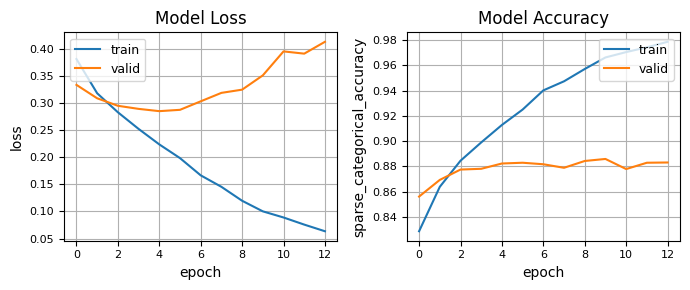

Model performance on the validation set: 0.8858000040054321


In [25]:
# increase dropout and number of epochs, add early stopping, constant learning rate
model_2 = get_model(dropout=0.2)
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=["sparse_categorical_accuracy"])
e_stop = tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_sparse_categorical_accuracy", restore_best_weights=True)
history = model_2.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[e_stop])

# plot summary
plot_history(history)
accuracy["FT-3"] = (get_performance(model_2, train_ds), get_performance(model_2, val_ds))
print("Model performance on the validation set:", accuracy["FT-3"][1])

All of the fine-tuned models have shown improvement over the baseline performance. However, model FT-3 overfits the training set the most. All fine-tuned models have almost identical performance on the test set. Notably, for this particular dataset, model FT-2 was easier and faster to train (no learning rate scheduling was applied) compared to the FT-1, which followed the recommendations from the paper. This phenomenon may have occurred because the baseline model loaded from the KerasNLP was already pre-trained on the sentiment dataset (SST-2), resulting in minimal shifts in model weights to adapt to the movie reviews dataset. Consequently, model FT-2 will be used in the inference process later because it overfits the training set the least while maintaining a reasonable level of performance on the validation set, and also its fine-tuning time and effort (number of epochs) were comparably lower.

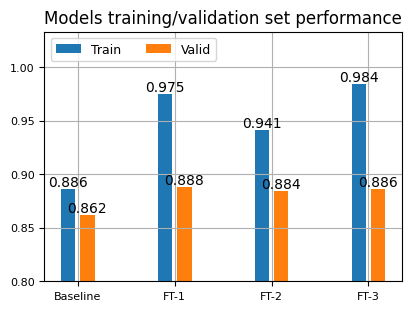

In [26]:
plot_stats(accuracy)

In [27]:
# save the best model
model_1.save("bert_tiny.keras")

# clear memory, delete unused models
tf.keras.backend.clear_session()
del model
del model_1
del model_2

## Inference

Rather than predicting hard sentiment classification labels, it may be more advantageous to map them to a sentiment range from -1 to 1, encompassing negative (-1), neutral (0), and positive (+1) sentiments.

In [28]:
# helper functions
def make_prediction(raw_review, model):
    """Args: 
    - raw_review: a single review of str type;
    - model: fine-tuned model.
    Outputs:
    - sentiment: a scalar that maps predicted review sentiments
    to fall into range [-1, 1]."""
    # convert a raw review into a tensor + batch dimension
    review = tf.expand_dims(tf.constant(raw_review), axis=0)
    # 2 neurons in the output layer, take the output of only 1 of them
    pred = model.predict(review, verbose=0)[:, 1]
    sentiment = tf.nn.tanh(pred)
    return sentiment.numpy()

def plot_bar(prediction):
    """Given a single scalar prediction plots it in a 
    colormap of a range [-1, 1]."""
    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)
    cmap = mpl.cm.bwr
    norm = mpl.colors.Normalize(vmin=-1, vmax=1)
    ticks = ["negative", "neutral", "positive"]
    bounds = [-1., 0.0, 1.0]
    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                    norm=norm,
                                    ticks=bounds,
                                    orientation='horizontal')
    cb1.ax.axvline(prediction, c='green', linewidth=3)
    cb1.ax.text(prediction, 1.1, s="prediction: "+str(round(prediction[0], 2)), 
                horizontalalignment="center", fontsize=9, c="green")
    cb1.set_ticklabels(ticks)
    cb1.set_label('Sentiment Scale')

In [30]:
# load  and compile saved model
model = tf.keras.models.load_model("bert_tiny.keras")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=["sparse_categorical_accuracy"])

`compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 84 variables. 


In [31]:
# evaluate the model on the held-out set in order to measure generalization error
print("Test set performance:", get_performance(model, test_ds))

Test set performance: 0.8805599808692932


Review: This movies was wonderful, however the music was not that good.


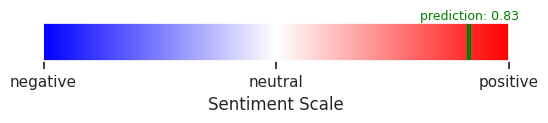

In [75]:
# test model prediction and plot result
review = "This movies was wonderful, however the music was not that good."
print("Review:", review)
plot_bar(make_prediction(review, model))

Review: It was okay, 5 out of 10, but i wouldn't watch it again.


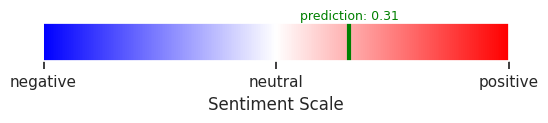

In [76]:
review = "It was okay, 5 out of 10, but i wouldn't watch it again."
print("Review:", review)
plot_bar(make_prediction(review, model))

Review: Movie is completely awful!


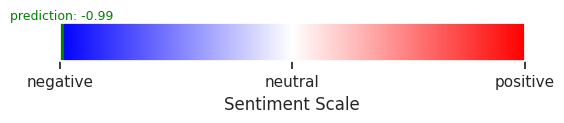

In [77]:
review = "Movie is completely awful!"
print("Review:", review)
plot_bar(make_prediction(review, model))

Review: tf.Tensor(b'Jack, Sawyer and Sayid swim to the boat and find a completely wasted Desmond. His traumatic past experience before sailing to the island is disclosed through flashbacks. Sayid plots a plan with Jack to surprise "The Others" in case Michael is double-crossing the group. John Locke convinces Desmond to invade the hatch, which is protected by Mr. Eko, and not press the button of the computer to see what will happen.<br /><br />This episode is one of the best of the Second Season. Unfortunately, we lovers of "Lost" can see the lack of respect the producers of this stunning series have with the fans. In the USA, the air date of this episode was 24 May 2006. Therefore, along this period, fans have to wait for the Third Season in a very suspenseful situation, with Jack and his group surrounded by "The Others" and finding the truth about Michael and the death of Ana Lucia and Libby; John locked inside the hatch without the intention of pushing the button and Mr. Eko in desp

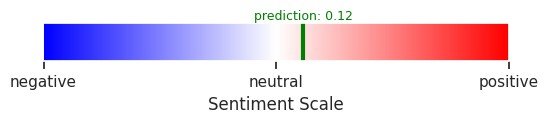

In [78]:
# test a review sampled from the test set
review_label = test_ds.unbatch().take(1)
for review, label in review_label:
    print("Review:", review)
    print("True label:", label.numpy())
    plot_bar(make_prediction(review, model))

## Error Analysis
1. Get a more detailed model performance report (confusion matrix and classification report)
2. Analyze errors using SHAP

In [79]:
# all the utility function required for error analysis part
def get_labels(dataset):
    """Returns true labels extracted from a tf.data.Dataset."""
    # get true labels
    return tf.stack([label for _, label in dataset.unbatch()], axis=0)

def get_preds(model, dataset):
    """Given a model and a dataset returns:
    y_pred - predicted labels
    y_proba - predicted class probabilities"""
    # raw model outputs
    logits = model.predict(dataset, verbose=0)
    # class probabilities
    y_proba = tf.nn.softmax(logits)
    # predicted labels
    y_pred = tf.cast(tf.argmax(logits, axis=1), tf.int32)
    return y_pred, y_proba

# utility functions to plot confusion matrix
def plot_confusion_matrix(actual, predicted, labels, ds_type):
    """Args:
    - actual - true labels,
    - predicted - predicted labels,
    - labels - class labels,
    - ds_type - inference data split name
    Returns: confusion plot."""
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt='g')
    sns.set(rc={'figure.figsize':(3.5, 3.5)})
    ax.set_title('Confusion matrix of sentiment prediction for ' + ds_type)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

# get a sample of misclassified examples
def sample_misclass(size, dataset, model):
    """Given model, dataset, sample size, returns a 
    sample of misclassified instances"""
    missclass = []
    y_pred, y_proba = get_preds(model, dataset)
    
    for i, item in dataset.unbatch().enumerate():
        if item[1] != y_pred[i]:
            if len(missclass) < size:
                missclass.append((item, y_proba[i]))
            else:
                break
    return missclass

def make_predictions(X):
    """Given a preloaded model and data to predict, returns raw predictions (logits)"""
    preds = model.predict(X, verbose=0)
    return preds

In [80]:
y_true = get_labels(test_ds)
y_pred, y_proba = get_preds(model, test_ds)

print("Labels:", y_true)
print("Predictions:", y_pred)
print("Probabilities:", y_proba)

Labels: tf.Tensor([1 0 1 ... 1 1 0], shape=(25000,), dtype=int32)
Predictions: tf.Tensor([0 0 1 ... 1 1 0], shape=(25000,), dtype=int32)
Probabilities: tf.Tensor(
[[0.5347477  0.46525228]
 [0.9803344  0.01966556]
 [0.02091571 0.97908425]
 ...
 [0.02534694 0.97465307]
 [0.02967547 0.9703245 ]
 [0.86158305 0.13841692]], shape=(25000, 2), dtype=float32)


Classification report:
               precision    recall  f1-score   support

         neg       0.89      0.88      0.88     12500
         pos       0.88      0.89      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



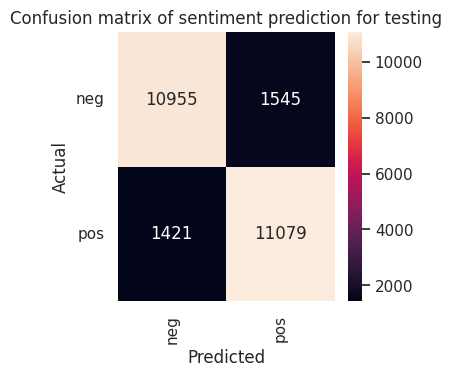

In [81]:
plot_confusion_matrix(y_true, y_pred, class_labels, "testing")
print("Classification report:\n", classification_report(y_true, y_pred, target_names=class_labels))

In [82]:
# output a few misclassified reviews
missclass = sample_misclass(size=3, dataset=test_ds, model=model)

for item, pred in missclass:
    print("\nReview:", item[0])
    print(f"True label: {item[1].numpy()} ({class_labels[item[1].numpy()]})")
    print(f"Predicted probability of negative class: {pred.numpy()[0]}, positive class: {pred.numpy()[1]}")


Review: tf.Tensor(b'Jack, Sawyer and Sayid swim to the boat and find a completely wasted Desmond. His traumatic past experience before sailing to the island is disclosed through flashbacks. Sayid plots a plan with Jack to surprise "The Others" in case Michael is double-crossing the group. John Locke convinces Desmond to invade the hatch, which is protected by Mr. Eko, and not press the button of the computer to see what will happen.<br /><br />This episode is one of the best of the Second Season. Unfortunately, we lovers of "Lost" can see the lack of respect the producers of this stunning series have with the fans. In the USA, the air date of this episode was 24 May 2006. Therefore, along this period, fans have to wait for the Third Season in a very suspenseful situation, with Jack and his group surrounded by "The Others" and finding the truth about Michael and the death of Ana Lucia and Libby; John locked inside the hatch without the intention of pushing the button and Mr. Eko in des

In [83]:
shap.initjs()

In [87]:
# set up masker and SHAP explainer
masker = shap.maskers.Text(tokenizer=r"\W+")
explainer = shap.Explainer(make_predictions, masker=masker, output_names=class_labels)

# extract review text from the misclassified examples sample
sampled_reviews = [str(text[0].numpy(), encoding='utf-8') for text, _ in missclass]

# SHAP masker applied to the input text
print("Sampled review:")
print(re.split(r"\W+", sampled_reviews[0]))

Sampled review:
['Jack', 'Sawyer', 'and', 'Sayid', 'swim', 'to', 'the', 'boat', 'and', 'find', 'a', 'completely', 'wasted', 'Desmond', 'His', 'traumatic', 'past', 'experience', 'before', 'sailing', 'to', 'the', 'island', 'is', 'disclosed', 'through', 'flashbacks', 'Sayid', 'plots', 'a', 'plan', 'with', 'Jack', 'to', 'surprise', 'The', 'Others', 'in', 'case', 'Michael', 'is', 'double', 'crossing', 'the', 'group', 'John', 'Locke', 'convinces', 'Desmond', 'to', 'invade', 'the', 'hatch', 'which', 'is', 'protected', 'by', 'Mr', 'Eko', 'and', 'not', 'press', 'the', 'button', 'of', 'the', 'computer', 'to', 'see', 'what', 'will', 'happen', 'br', 'br', 'This', 'episode', 'is', 'one', 'of', 'the', 'best', 'of', 'the', 'Second', 'Season', 'Unfortunately', 'we', 'lovers', 'of', 'Lost', 'can', 'see', 'the', 'lack', 'of', 'respect', 'the', 'producers', 'of', 'this', 'stunning', 'series', 'have', 'with', 'the', 'fans', 'In', 'the', 'USA', 'the', 'air', 'date', 'of', 'this', 'episode', 'was', '24', 'M

The base value is what the model outputs when the entire input text is masked, while **f_outputclass(inputs)** is the output of the model for the full original input. The SHAP values explain in an addive way how the impact of unmasking each word changes the model output from the base value (where the entire input is masked) to the final prediction value. SHAP requires tensor outputs from the classifier, and explanations works best in additive spaces (logits or information values instead of probabilities).

In [88]:
shap_values = explainer(sampled_reviews)
shap.text_plot(shap_values)

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|██████████████▎                            | 1/3 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|███████████████████████████████████| 3/3 [03:15<00:00, 49.98s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 4it [04:50, 96.87s/it]                                                


It has been observed that some reviews consist of multiple parts discussing different aspects of the movie, such as plot, music, acting etc. Consequently, it might be more beneficial to predict sentiment for each aspect separately. Moreover, different parts of a review may exhibit varying sentiments, making it challenging to predict an overall sentiment accurately. For instance, the true label of the first out of 3 reviews, explained using SHAP, is positive (1). However, upon closer inspection, it becomes clear that the movie plot summary has influenced the model's prediction more toward a negative sentiment label (0).